In [1]:
pip install solar-wavelength-calibration

  Using cached solar_wavelength_calibration-1.0-py3-none-any.whl.metadata (6.3 kB)
Using cached solar_wavelength_calibration-1.0-py3-none-any.whl (38 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
from solar_wavelength_calibration import WavelengthCalibrationFitter, WavelengthCalibrationParameters
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

## Basic Usage

Define the spectrum to be fit and compute the expected wavelength vector based on header information:

In [3]:
input_spectrum = np.arange(0.8, 1.0, 0.01)

input_wavelength_vector = np.arange(1067.5, 1076.3, 0.01) * u.nm

Set up the model parameters using values specific to your instrument:

In [4]:
input_parameters = WavelengthCalibrationParameters(
        crval=350.159 * u.nm,
        dispersion=4.042 * u.nm/u.pix,
        incident_light_angle=57.006 * u.deg,
        resolving_power=42500,
        opacity_factor=5.0,
        straylight_fraction=0.2,
        grating_constant=31600.0 * 1/u.m,
        doppler_velocity=-0.428 * u.km/u.s,
        order=52,
    )


Initialize the wavelength calibration fitter:

In [5]:
fitter = WavelengthCalibrationFitter(
        input_parameters=input_parameters,
    )

Perform the wavelength calibration fit:

In [6]:
fit_result = fitter(
        input_wavelength_vector=input_wavelength_vector,
        input_spectrum=input_spectrum,
    )


Check out the results!

In [12]:
corrected_header = fit_result.wavelength_parameters.to_header(
                    axis_num=1)
#corrected_header = fit_result.wavelength_parameters.to_header(axis_num=1, add_alternate_keys=True)

corrected_header

{'CTYPE1': 'AWAV-GRA',
 'CUNIT1': 'nm',
 'CRPIX1': 11,
 'CRVAL1': 350.1590000000001,
 'CDELT1': 4.042000000000001,
 'PV1_0': 31600.0,
 'PV1_1': 52,
 'PV1_2': 57.006}

ValueError: x and y must have same first dimension, but have shapes (880,) and (20,)

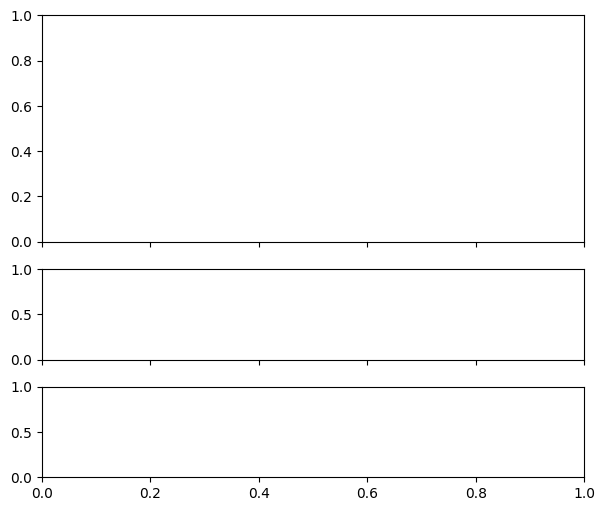

In [13]:
corrected_wcs = WCS(corrected_header)

number_of_wave_pix = np.size(input_spectrum)

fitted_wave = (
    corrected_wcs.spectral.pixel_to_world(np.arange(number_of_wave_pix))
).to_value(u.nm)

aligned_solar_transmission = fit_result.minimizer_result.residual + input_spectrum

fig, ax = plt.subplots(3, 1, figsize=(7, 6), height_ratios=[1, 0.4, 0.4], sharex=True)
ax[0].plot(input_wavelength_vector, input_spectrum, label="Input Spectrum")
ax[0].plot(
    fitted_wave,
    aligned_solar_transmission,
    label="Doppler-Shifted Solar Atlas",
    linestyle="-",
    color="k",
    alpha=0.3,
)
ax[0].plot(fitted_wave, input_spectrum, label="Corrected Spectrum")
ax[0].legend()
ax[0].set_ylabel("Intensity")
residuals = fit_result.minimizer_result.residual
ax[1].plot(fitted_wave, residuals, label="Residuals")
ax[1].legend()
#ax[2].plot(input_wavelength_vector, weights, label="Weights")
#ax[2].set_xlabel("Wavelength (nm)")
#ax[2].legend()
fig.suptitle("Corrected Spectrum vs Input Spectrum")
fig.tight_layout()
plt.show()

## Advanced Usage

Using your own reference atlas

Smart CRVAL initial parameter estimation

Setting bounds for the model

Setting weights for the model

Changing the optimization method

Freezing parameters